### Import Package

In [176]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Main Code

In [177]:
class Bandit:
    def __init__(self, num_bins, d):
        self.num_bins = num_bins
        self.d = d
        self.beta_parameters = np.zeros((d, num_bins))
        self.bin_boundaries = np.linspace(0, 100, num_bins + 1)
        self.uncertainties = np.ones((d, num_bins))/2
        self.time_step = 0
        self.sum_xt_sq = np.zeros((d, num_bins))
        self.sum_xt_yt = np.zeros((d, num_bins))

    def update_parameters(self, max_risk_score, true_severity, index):
        self.time_step += 1

        for j in range(self.num_bins):
            for k in range(self.d):
                if self.bin_boundaries[j]<max_risk_score[k]<self.bin_boundaries[j+1]:
                    self.sum_xt_sq[k][j] += max_risk_score[k] ** 2
                    if k==index:
                        self.sum_xt_yt[k][j] += max_risk_score[k] * true_severity

        for j in range(self.num_bins):
            for k in range(self.d):
                if self.sum_xt_sq[k][j] != 0:
                    delta = 5
                    self.beta_parameters[k][j] = self.sum_xt_yt[k][j] / self.sum_xt_sq[k][j]
                    self.uncertainties[k][j] = np.sqrt(np.log(delta)/ self.sum_xt_sq[k][j])

class BanditAgent:
    def __init__(self, num_bins, manual_reviewer, d):
        self.num_bins = num_bins
        self.d = d
        self.bandit = Bandit(num_bins, d)
        self.content_pool = []
        self.manual_reviewer = manual_reviewer

    def scale_risk_score(self, content):
        temp = self.f(content)
        return np.argmax(temp),max(temp)

    def f(self, content):
        result = np.zeros(self.d)
        for j in range(self.num_bins):
            for k in range(self.d):
                if self.bandit.bin_boundaries[j] <= content[k] < self.bandit.bin_boundaries[j + 1]:
                    a_ij = self.bandit.beta_parameters[k][j] + self.bandit.uncertainties[k][j]
                    result[k] = a_ij * content[k]
        return result

    def update_bandit(self):
        if len(self.content_pool) == 0:
            return

        max_risk_score = -np.inf
        content_to_review = None
        ind = -1

        for content in self.content_pool:
            t_arg, risk_score = self.scale_risk_score(content)
            #print(risk_score)
            if risk_score > max_risk_score:
                max_risk_score = risk_score
                content_to_review = content
                ind = t_arg

        if max_risk_score > 0:
            true_severity = self.manual_reviewer(self.bandit.time_step, max_risk_score)  # Manual Review (Random for this simulation)
            self.bandit.update_parameters(content_to_review, true_severity, ind)


### Test 1

This follows manual reviewer marking feature 3 as highly violating for first 500 seconds and then the feature 3 is more violating. Content always follows the same distribution (normal distribution around 10 for feature 3 and around 20 for feature 2)

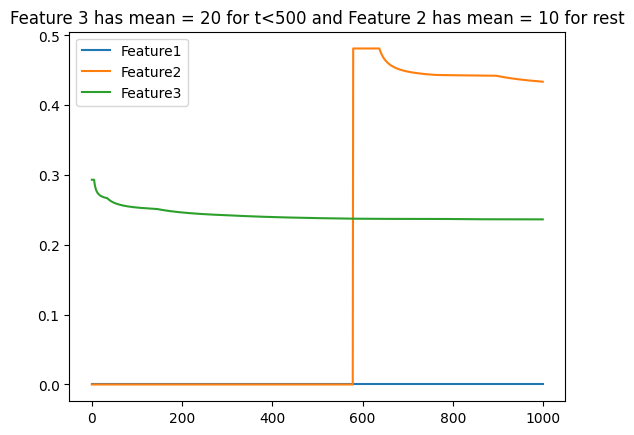

In [178]:
def manual_reviewer(t, r):
    return 10

# Define the number of bins and their boundaries
num_bins = 1

d = 3 # Dimensions of content

num_iterations = 1000

def generate_content(t):
    res = np.zeros(d)
    if(t<500):
        res[2] = np.random.normal(30,5,1)[0]
        res[0] = 0
        res[1] = 0
    else:
        res[1] = np.random.normal(10,5,1)[0]
        res[2] = 0 #np.random.normal(0.5,0.1,1)[0]
        res[0] = 0
    return res

# Create RiskBanditAgent instance
agent = BanditAgent(num_bins, manual_reviewer, d)

beta_parameter_evolution = []

# Main loop
for t in range(num_iterations):
    content = generate_content(t)
    agent.content_pool.append(content)
    agent.update_bandit()
    beta_parameter_evolution.append(agent.bandit.beta_parameters.copy())

beta_parameter_evolution = np.array([array.reshape(3) for array in beta_parameter_evolution])
plt.plot(beta_parameter_evolution)
plt.legend(['Feature1', 'Feature2', 'Feature3'])
plt.title ('Feature 3 has mean = 20 for t<500 and Feature 2 has mean = 10 for rest')
plt.show()

### Test 2

This test is about at randoml times different type of features having big impacts. For ex, at t = 5 content can be [0, 1, 10] while at t=6 it is [0,10,1]

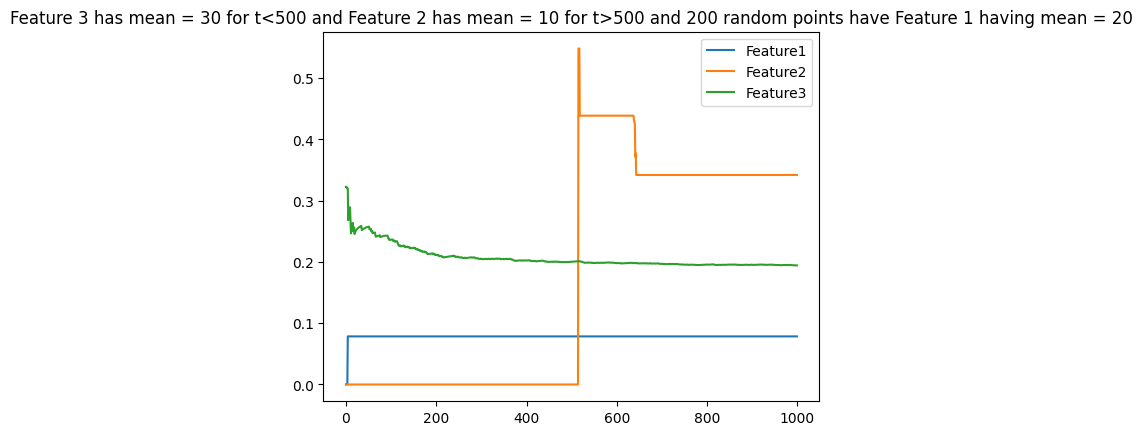

In [179]:
random_time_points1 = np.sort(np.random.choice(range(500), size=100, replace=False))
random_time_points2 = np.sort(np.random.choice(range(500,1000), size=100, replace=False))

def manual_reviewer(t, r):
    if(t in random_time_points1 or t in random_time_points2 or (t>=1000 and t<1005)):
        return 2
    return 10

def generate_content(t):
    res = np.zeros(d)
    if(t in random_time_points1 or t in random_time_points2):
        res[2] = 0
        res[0] = np.random.normal(20,5,1)[0]
        res[1] = 0
    elif t<500:
        res[2] = np.random.normal(30,5,1)[0]
        res[1] = 0 #np.random.normal(0.5,0.1,1)[0]
        res[0] = 0
    else:
        res[1] = np.random.normal(10,5,1)[0]
        res[2] = 0 #np.random.normal(0.5,0.1,1)[0]
        res[0] = 0
    return res        
        

# Create RiskBanditAgent instance
agent = BanditAgent(num_bins, manual_reviewer, d)

beta_parameter_evolution = []

# Main loop
for t in range(num_iterations):
    content = generate_content(t)
    agent.content_pool.append(content)
    agent.update_bandit()
    beta_parameter_evolution.append(agent.bandit.beta_parameters.copy())

beta_parameter_evolution = np.array([array.reshape(3) for array in beta_parameter_evolution])
plt.plot(beta_parameter_evolution)
plt.legend(['Feature1', 'Feature2', 'Feature3'])
plt.title ('Feature 3 has mean = 30 for t<500 and Feature 2 has mean = 10 for t>500 and 200 random points have Feature 1 having mean = 20')
plt.show()

### Yt Test

In [183]:
def generate_content(t):
    res = np.zeros(d)
    if t<5:
        res[0] = np.random.normal(15,5,1)[0]
        res[1] = 0 #np.random.normal(0.5,0.1,1)[0]
        res[2] = 0
    else:
        res[1] = np.random.normal(10,5,1)[0]
        res[2] = 0 #np.random.normal(0.5,0.1,1)[0]
        res[0] = 0
    return res

data = []
for t in range(10):
    content = generate_content(t)
    data.append(agent.scale_risk_score(content))

df = pd.DataFrame(data, columns=['Policy violated', 'yt predicted'])
df.head(10)
    
    
    


,Policy violated,yt predicted
0,0,3.160539
1,0,1.186004
2,0,3.137100
3,0,1.844438
4,0,2.225931
5,1,5.666453
6,1,4.338787
7,1,3.809914
8,1,3.751374
9,1,3.586835


### Trivial Test

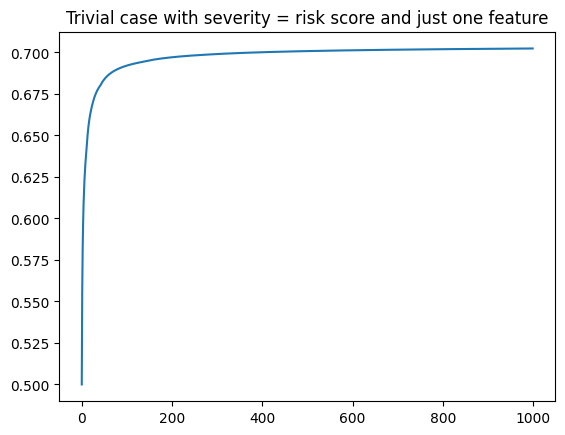

In [ ]:
d = 1
def manual_reviewer(t, r):
    return r

# Create RiskBanditAgent instance
agent = BanditAgent(num_bins, manual_reviewer, d)

beta_parameter_evolution = []

# Main loop
for t in range(num_iterations):
    content = np.random.normal(10,5,1)
    agent.content_pool.append(content)
    agent.update_bandit()
    beta_parameter_evolution.append(agent.bandit.beta_parameters.copy())

beta_parameter_evolution = np.array([array.reshape(1) for array in beta_parameter_evolution])
plt.plot(beta_parameter_evolution)
plt.title('Trivial case with severity = risk score and just one feature')
plt.show()
    